In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from mixedbridge.solvers.sde import Euler
from mixedbridge.stochastic_processes.wiener import WienerProcess
from mixedbridge.stochastic_processes.examples import CellDiffusionProcess, CellDiffusionAuxProcess
from mixedbridge.stochastic_processes.gbp import GuidedBridgeProcess
from mixedbridge.baselines.pcn import PreconditionedCrankNicolson

In [3]:
dim = 2
alpha = 1. / 16.
sigma = 0.1
T = 4.0
dt = 1./500
dtype = jnp.float32
rng_key = jax.random.PRNGKey(42)
x0 = jnp.array([0.1, -0.1], dtype=dtype)
xT = jnp.array([2.0, -0.1], dtype=dtype)

In [4]:
wiener_process = WienerProcess(dim=dim, dtype=dtype, T=T, dt=dt)
sde = CellDiffusionProcess(alpha, sigma, T=T, dt=dt)
solver = Euler(sde, wiener_process)

n_batches = 100
path = solver.solve(x0, dWs=None, rng_key=rng_key, n_batches=n_batches)

Text(0.5, 1.0, 'Unconditional process')

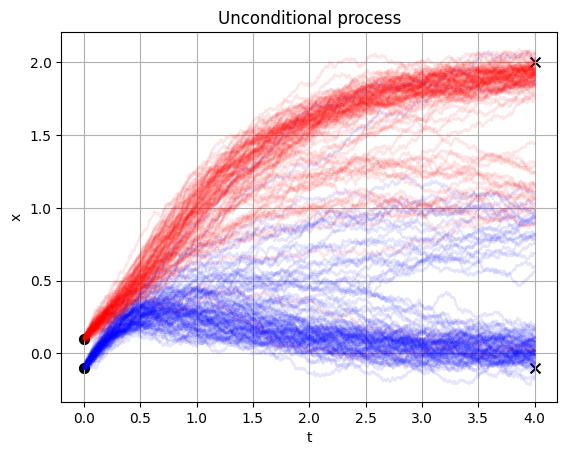

In [5]:
for i in range(n_batches):
    plt.plot(path.ts, path.xs[i, :, 0], color='r', alpha=0.1)
    plt.plot(path.ts, path.xs[i, :, 1], color='b', alpha=0.1)
plt.scatter(0.0, x0[0], color='black', marker='o', s=50)
plt.scatter(0.0, x0[1], color='black', marker='o', s=50)
plt.scatter(T, xT[0], color='black', marker='x', s=50)
plt.scatter(T, xT[1], color='black', marker='x', s=50)
plt.xlabel('t')
plt.ylabel('x')
plt.grid()
plt.title("Unconditional process")

In [6]:
aux_sde = CellDiffusionAuxProcess(alpha, sigma, T=4.0, dt=1./500.)
L0 = jnp.eye(dim, dtype=dtype)
Sigma0 = jnp.eye(dim, dtype=dtype) * 1e-10
guided_sde = GuidedBridgeProcess(sde, aux_sde, L0, Sigma0, start=x0, target=xT)
solver = Euler(guided_sde, wiener_process)
path = solver.solve(x0, dWs=None, rng_key=rng_key, log_likelihood=True, n_batches=n_batches)

Text(0.5, 1.0, 'Guided process')

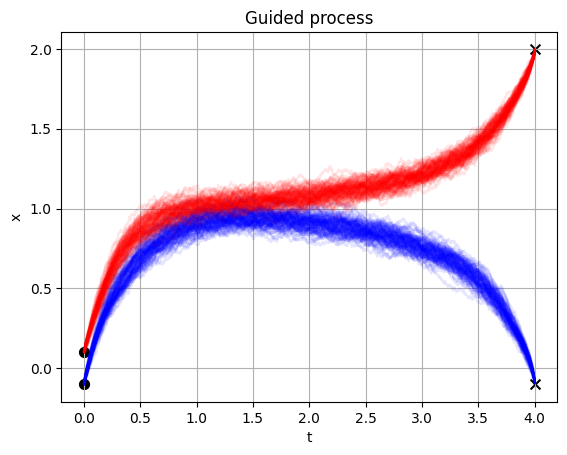

In [7]:
for i in range(n_batches):
    plt.plot(path.ts, path.xs[i, :, 0], color='r', alpha=0.1)
    plt.plot(path.ts, path.xs[i, :, 1], color='b', alpha=0.1)
plt.scatter(0.0, x0[0], color='black', marker='o', s=50)
plt.scatter(0.0, x0[1], color='black', marker='o', s=50)
plt.scatter(T, xT[0], color='black', marker='x', s=50)
plt.scatter(T, xT[1], color='black', marker='x', s=50)
plt.xlabel('t')
plt.ylabel('x')
plt.grid()
plt.title("Guided process")

In [8]:
mcmc_model = PreconditionedCrankNicolson(
    rho=0.98,
    x0=x0,
    guided_process=guided_sde,
    rng_key=jax.random.PRNGKey(42),
    n_batches=16
)
path_mcmc, lls = mcmc_model.update(n_iters=2000, verbose=True, log_every=100)

Iteration 1/2000: log likelihood = 108.06700134277344
Iteration 101/2000: log likelihood = 134.97328186035156
Iteration 201/2000: log likelihood = 137.82614135742188
Iteration 301/2000: log likelihood = 144.1864013671875
Iteration 401/2000: log likelihood = 157.6217041015625
Iteration 501/2000: log likelihood = 157.84432983398438
Iteration 601/2000: log likelihood = 151.93365478515625
Iteration 701/2000: log likelihood = 161.96290588378906
Iteration 801/2000: log likelihood = 156.0941162109375
Iteration 901/2000: log likelihood = 156.7057342529297
Iteration 1001/2000: log likelihood = 152.4219207763672
Iteration 1101/2000: log likelihood = 158.2425537109375
Iteration 1201/2000: log likelihood = 158.94338989257812
Iteration 1301/2000: log likelihood = 169.32252502441406
Iteration 1401/2000: log likelihood = 164.22158813476562
Iteration 1501/2000: log likelihood = 161.9203338623047
Iteration 1601/2000: log likelihood = 168.55548095703125
Iteration 1701/2000: log likelihood = 172.24250793

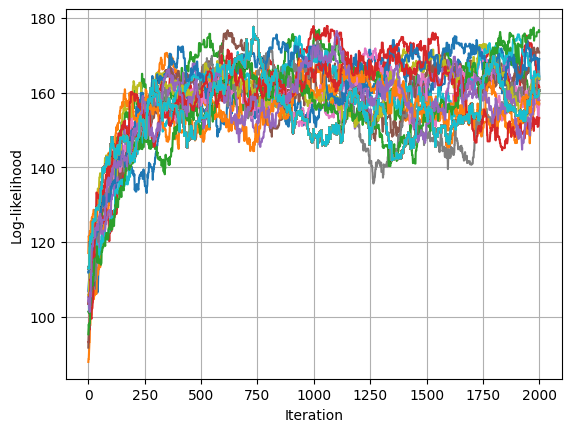

In [9]:
for i in range(n_batches):
    plt.plot(lls[:, i])
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.grid()
# plt.savefig('./cell_mcmc_lls.png', dpi=150, bbox_inches='tight')

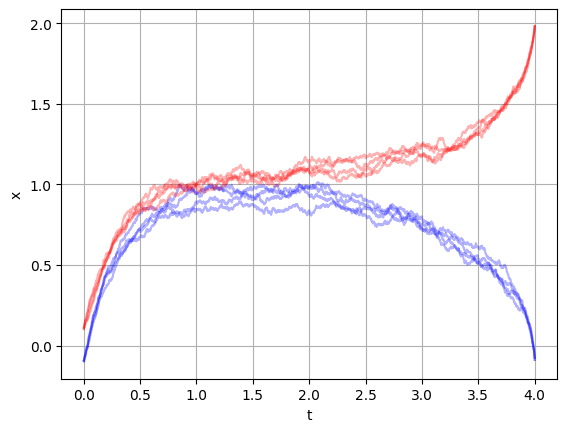

In [10]:
for i in range(4):
    # plt.plot(path.ts, path.xs[i, :, 0], color='r', alpha=0.1)
    # plt.plot(path.ts, path.xs[i, :, 1], color='b', alpha=0.1)
    plt.plot(path_mcmc.ts, path_mcmc.xs[i, :, 0], color='r', alpha=0.3)
    plt.plot(path_mcmc.ts, path_mcmc.xs[i, :, 1], color='b', alpha=0.3)
plt.xlabel('t')
plt.ylabel('x')
plt.grid()
# plt.savefig('./cell_mcmc_sample.png', dpi=150, bbox_inches='tight')